In [1]:
import furuta_sympy_calc as furu_calc
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import furuta_params

furuta_params = furuta_params.FurutaParams() #wird automatisch mit aktiver reibung und mP = 0 initialisiert
tau_max = furuta_params.tau_max

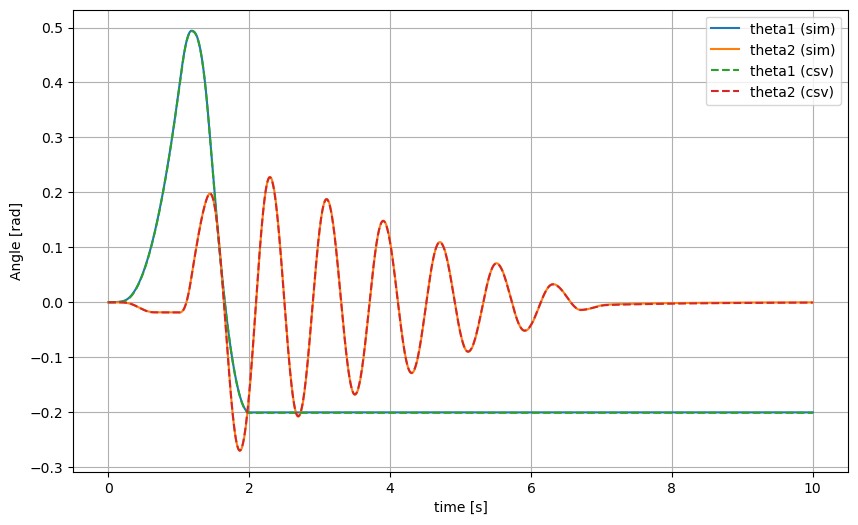

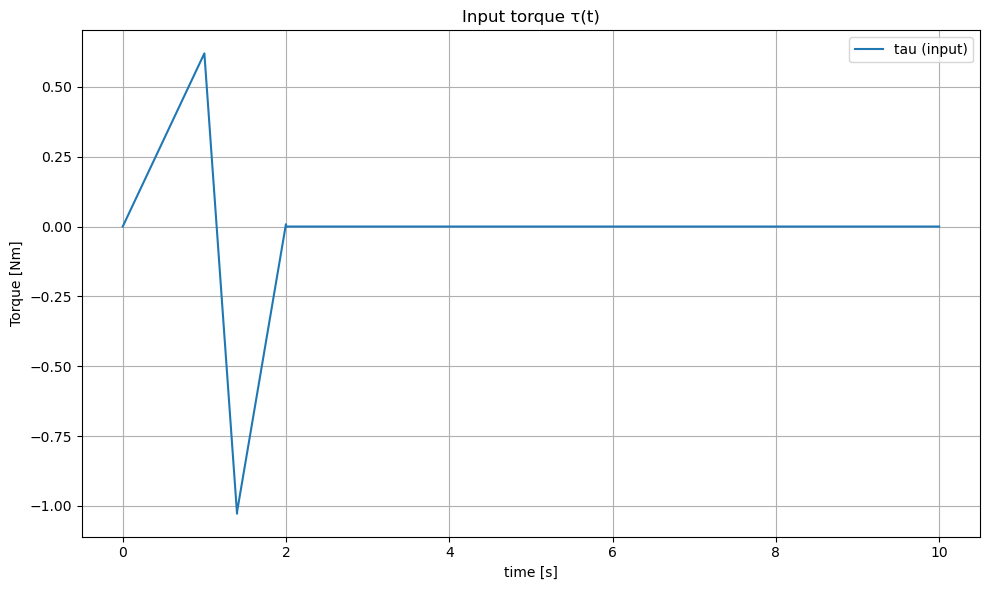

RMSE theta1: 0.0007381086951967028
RMSE theta2: 0.0011584304555831014


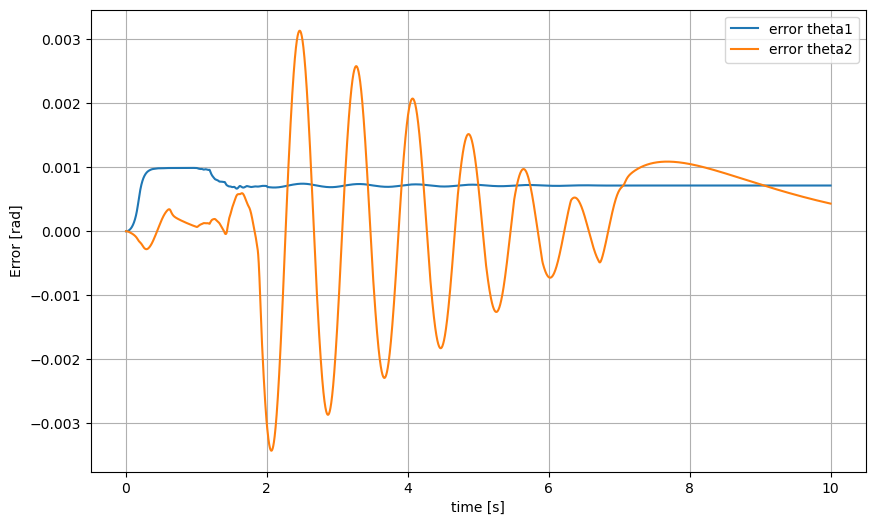

In [2]:
# ==========================================================
# Eingangsfunktion aus 3.4 (HIER 1:1 einsetzen)
# ==========================================================
def input_tau(t: float) -> float:
    # TODO: exakt eure 3.4-Funktion hier einsetzen (dein bisheriger Block ist nur Platzhalter)
    if 0 < t < 1.0:
        tau = 0.62 * t
    elif 1 <= t <= 1.4:
        tau = -4.12 * t + 4.74
    elif 1.4 < t < 2:
        tau = 1.72 * t - 3.43
    else:
        tau = 0.0

    return float(np.clip(tau, -tau_max, tau_max))


non_linear_furuta_system = furu_calc.get_non_linear_furuta_system(furuta_params)
def simulation_system(t, x):
    theta1, theta1_dot, theta2, theta2_dot = x
    u = input_tau(t)
    return non_linear_furuta_system(t, x, u)


# ==========================================================
# Simulation + CSV Vergleich
# ==========================================================
df = pd.read_csv("validationSimulation.csv")
t_csv = df["time"].values
theta1_csv = df["F: theta1"].values
theta2_csv = df["F: theta2"].values

# Anfangszustand (wie bei dir; muss ggf. zur CSV passen)
x0 = [0.0, 0.0, 0.0, 0.0]

# Tipp: direkt auf CSV-Zeitpunkten integrieren, damit Vergleich 1:1 ist
sol = solve_ivp(
    simulation_system,
    (float(t_csv[0]), float(t_csv[-1])),
    x0,
    t_eval=t_csv,
    rtol=1e-6,
    atol=1e-9,
    max_step=1e-2,
)

theta1_sim = sol.y[0]
theta2_sim = sol.y[2]
tau_sim = np.array([input_tau(t) for t in t_csv])

plt.figure(figsize=(10, 6))
plt.plot(t_csv, theta1_sim, label="theta1 (sim)")
plt.plot(t_csv, theta2_sim, label="theta2 (sim)")
plt.plot(t_csv, theta1_csv, "--", label="theta1 (csv)")
plt.plot(t_csv, theta2_csv, "--", label="theta2 (csv)")
plt.ylabel("Angle [rad]")
plt.xlabel("time [s]")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Separater Plot für das Eingangsmoment tau(t)
# ==========================================================
plt.figure(figsize=(10, 6))
plt.plot(t_csv, tau_sim, label="tau (input)")
plt.ylabel("Torque [Nm]")
plt.xlabel("time [s]")
plt.title("Input torque τ(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Optional: Fehlerplot + RMSE
e1 = theta1_sim - theta1_csv
e2 = theta2_sim - theta2_csv
rmse1 = np.sqrt(np.mean(e1**2))
rmse2 = np.sqrt(np.mean(e2**2))
print("RMSE theta1:", rmse1)
print("RMSE theta2:", rmse2)

plt.figure(figsize=(10, 6))
plt.plot(t_csv, e1, label="error theta1")
plt.plot(t_csv, e2, label="error theta2")
plt.ylabel("Error [rad]")
plt.xlabel("time [s]")
plt.legend()
plt.grid(True)
plt.show()